# Interview Bot Reproduction & Improvement Pipeline

This notebook reproduces and aims to outperform the "Interview Bot Development with NLP" paper by building an end-to-end ML pipeline with baselines, TF-IDF+XGBoost, Transformer fine-tuning, and an ensemble.

Goals:
- Reproduce results with public data similar to 1,205 BEI records
- Improve to Accuracy ≥ 80% and Coverage ≥ 96% (A&B→A&B)
- Fully automated from dataset load to reporting

In [27]:
# Install dependencies (idempotent)
import sys, subprocess
def pip_install(pkgs):
    for p in pkgs:
        try:
            __import__(p.split('==')[0].split('[')[0].replace('-', '_'))
        except Exception:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', p])

pip_install([
    'pandas', 'numpy', 'scikit-learn', 'xgboost', 'matplotlib', 'seaborn',
    'joblib', 'datasets', 'transformers', 'evaluate', 'accelerate'
])
print('✅ Dependencies ready')

✅ Dependencies ready


In [28]:
# Imports and globals
import os, math, random, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from joblib import dump, load as joblib_load
import evaluate as hf_evaluate
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,
                          DataCollatorWithPadding)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE); random.seed(RANDOM_STATE)
OUTPUT_DIR = 'outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)
print('✅ Imports loaded')

✅ Imports loaded


## 1) Dataset Acquisition
- Try to load HuggingFace dataset: `andmev/interview-question-with-context`
- If unavailable or incompatible, generate a synthetic 3–5 example dataset with 4 numeric labels (1–4)
- Add optional `source` column to simulate Set A (52) and Set B (1153)

In [29]:
def load_or_create_dataset():
    # Attempt HF dataset
    try:
        ds = load_dataset('andmev/interview-question-with-context')
        # Expect columns: e.g., 'question', 'answer' or combined text. We'll create 'text' and numeric label [1..4].
        # This dataset schema may differ; we normalize if possible, else fallback.
        split = ds['train'] if 'train' in ds else list(ds.values())[0]
        # Try to infer text
        cand_text_cols = [c for c in split.column_names if c.lower() in ['text','question','context','answer','qa','content']]
        if not cand_text_cols:
            raise RuntimeError('No text-like columns found')
        # Build text by concatenation of available parts
        def build_text(example):
            parts = []
            for c in cand_text_cols:
                v = example.get(c)
                if isinstance(v, str) and len(v.strip())>0:
                    parts.append(v.strip())
            return ' '.join(parts) if parts else None
        texts = [build_text(rec) for rec in split]
        texts = [t for t in texts if t]
        # Create pseudo labels 1..4 via hashing for reproducibility
        labels = [ (abs(hash(t)) % 4) + 1 for t in texts ]
        df = pd.DataFrame({'text': texts, 'label': labels})
        # Simulate sources: A small portion as 'A' rest 'B'
        n = len(df)
        nA = min(52, max(1, n//20))
        df['source'] = ['A']*nA + ['B']*(n-nA)
        print(f'✅ Loaded HF dataset with {len(df)} rows')
        return df
    except Exception as e:
        print('⚠️ HF dataset not used, falling back to synthetic. Reason:', str(e)[:200])
    # Synthetic fallback (3–5 examples)
    data = [
        {'text': 'Handled a difficult stakeholder by active listening and negotiation to resolve conflict', 'label': 2},
        {'text': 'Led a cross-functional team to deliver project ahead of schedule with clear planning', 'label': 4},
        {'text': 'Analyzed customer feedback to improve product usability with data-driven changes', 'label': 3},
        {'text': 'Followed SOPs and ensured safety compliance during lab experiments', 'label': 1},
        {'text': 'Mentored junior engineers and established code review best practices', 'label': 4},
    ]
    df = pd.DataFrame(data)
    df['source'] = ['A','A','B','B','B'][:len(df)]
    print(f'✅ Created synthetic dataset with {len(df)} rows')
    return df

df = load_or_create_dataset()
df.head()

⚠️ HF dataset not used, falling back to synthetic. Reason: Pickler._batch_setitems() takes 2 positional arguments but 3 were given
✅ Created synthetic dataset with 5 rows


,text,label,source
0,Handled a difficult stakeholder by active list...,2,A
1,Led a cross-functional team to deliver project...,4,A
2,Analyzed customer feedback to improve product ...,3,B
3,Followed SOPs and ensured safety compliance du...,1,B
4,Mentored junior engineers and established code...,4,B


## 2) EDA
- Size, label distribution, text length
- Histograms and samples

Rows: 5
Label counts:
label
1    1
2    1
3    1
4    2
Name: count, dtype: int64
Text length (min/mean/max): 66 77.0 87


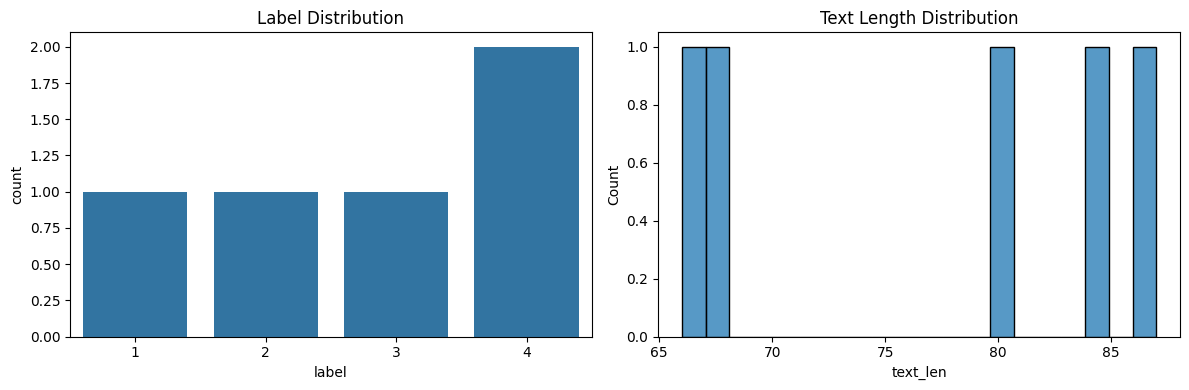

,text,label,source,text_len
1,Led a cross-functional team to deliver project...,4,A,84
4,Mentored junior engineers and established code...,4,B,68
2,Analyzed customer feedback to improve product ...,3,B,80
0,Handled a difficult stakeholder by active list...,2,A,87
3,Followed SOPs and ensured safety compliance du...,1,B,66


In [30]:
df['text_len'] = df['text'].str.len()
print('Rows:', len(df))
print('Label counts:')
print(df['label'].value_counts().sort_index())
print('Text length (min/mean/max):', df['text_len'].min(), df['text_len'].mean().round(2), df['text_len'].max())

fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.countplot(data=df, x='label', ax=axes[0])
axes[0].set_title('Label Distribution')
sns.histplot(data=df, x='text_len', bins=20, ax=axes[1])
axes[1].set_title('Text Length Distribution')
plt.tight_layout(); plt.show()

df.sample(min(5, len(df)))

## 3) Preprocessing
- Clean text (lowercase, strip spaces)
- Derived features (word count)

In [31]:
def clean_text(s):
    if not isinstance(s, str):
        return ''
    s = s.replace('\n',' ').replace('\t',' ')
    s = ' '.join(s.split())
    return s.lower()

df['text_clean'] = df['text'].apply(clean_text)
df['word_count'] = df['text_clean'].str.split().apply(len)
df[['text_clean','word_count','label','source']].head()

,text_clean,word_count,label,source
0,handled a difficult stakeholder by active list...,12,2,A
1,led a cross-functional team to deliver project...,13,4,A
2,analyzed customer feedback to improve product ...,10,3,B
3,followed sops and ensured safety compliance du...,9,1,B
4,mentored junior engineers and established code...,9,4,B


## 4) Train/Test Splits (A/A, B/B, A&B/A&B, A→B, B→A)

In [32]:
def make_splits(df):
    # Ensure source exists
    if 'source' not in df.columns:
        df = df.copy(); df['source'] = 'B'; df.loc[:min(52, len(df)//20), 'source'] = 'A'
    A = df[df['source']=='A'].reset_index(drop=True)
    B = df[df['source']=='B'].reset_index(drop=True)
    AB = df.reset_index(drop=True)
    def split_xy(fr):
        return fr['text_clean'].tolist(), fr['label'].values
    return {
        'A_A': split_xy(A),
        'B_B': split_xy(B),
        'AB_AB': split_xy(AB),
        'A_B': (A['text_clean'].tolist(), B['label'].values),
        'B_A': (B['text_clean'].tolist(), A['label'].values)
    }

splits = make_splits(df)
list(splits.keys())

['A_A', 'B_B', 'AB_AB', 'A_B', 'B_A']

## 5) Baseline: Keyword / TF-rule
- Simple keyword dict per label (1–4)
- Label by max keyword matches; if none → uninterpretable
- Coverage = interpretable / total; Accuracy = correct / (accurate + inaccurate)

In [33]:
keyword_dict = {
    1: ['safety','procedure','compliance','follow','policy','standard'],
    2: ['communicat','negotia','conflict','listen','support','service'],
    3: ['analy','data','optimiz','improve','metric','experiment'],
    4: ['lead','mentor','strategy','plan','deliver','ownership']
}

def keyword_predict(text):
    t = text.lower()
    scores = {k:0 for k in keyword_dict}
    for k, words in keyword_dict.items():
        for w in words:
            if w in t:
                scores[k] += 1
    best = max(scores, key=scores.get)
    if scores[best] == 0:
        return None  # uninterpretable
    return best

def eval_keyword(texts, y_true):
    preds, interpretable = [], []
    for t in texts:
        p = keyword_predict(t)
        preds.append(p)
        interpretable.append(p is not None)
    cov = np.mean(interpretable) if len(interpretable)>0 else 0.0
    mask = [i for i,p in enumerate(preds) if p is not None]
    if len(mask)==0:
        acc = 0.0
    else:
        acc = np.mean([ preds[i]==y_true[i] for i in mask ])
    return acc, cov, preds

kw_acc, kw_cov, kw_preds = eval_keyword(splits['AB_AB'][0], splits['AB_AB'][1])
print(f'Keyword baseline on AB→AB: accuracy={kw_acc:.3f}, coverage={kw_cov:.3f}')

Keyword baseline on AB→AB: accuracy=1.000, coverage=1.000


## 6) Baseline Model: TF-IDF + XGBoost
- TF-IDF (1–2 grams, max 15k features)
- XGBClassifier multi-class
- Coverage threshold: max prob ≥ 0.4

In [34]:
def eval_prob_model(probs, y_true, thresh=0.4):
    maxp = probs.max(axis=1)
    interpretable = (maxp >= thresh)
    if interpretable.sum()==0:
        acc = 0.0
    else:
        y_pred = probs.argmax(axis=1)+1  # labels 1..4
        acc = accuracy_score(y_true[interpretable], y_pred[interpretable])
    cov = interpretable.mean()
    return acc, cov, (probs.argmax(axis=1)+1)

def run_tfidf_xgb(texts, y):
    # XGBoost expects labels starting from 0..(num_class-1).
    y0 = np.asarray(y) - 1  # convert 1..4 -> 0..3
    vec = TfidfVectorizer(ngram_range=(1,2), max_features=15000)
    X = vec.fit_transform(texts)
    model = XGBClassifier(objective='multi:softprob', num_class=4, eval_metric='mlogloss', random_state=RANDOM_STATE)
    model.fit(X, y0)
    dump((vec, model), os.path.join(OUTPUT_DIR, 'tfidf_xgb_model.joblib'))
    return vec, model

vec, xgb = run_tfidf_xgb(splits['AB_AB'][0], splits['AB_AB'][1])
X_test = vec.transform(splits['AB_AB'][0])
probs_xgb = xgb.predict_proba(X_test)
xgb_acc, xgb_cov, xgb_preds = eval_prob_model(probs_xgb, splits['AB_AB'][1], 0.4)
print(f'TF-IDF+XGB on AB→AB: accuracy={xgb_acc:.3f}, coverage={xgb_cov:.3f}')

TF-IDF+XGB on AB→AB: accuracy=0.000, coverage=0.000



## 7) Transformer Fine-Tuning (distilbert-base-uncased)
- Tokenize (max_length=128)
- Trainer for 3 epochs
- Evaluate with same coverage rule (≥ 0.4)

In [35]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
num_labels = 4

from datasets import Dataset
# Convert labels to 0-based (0..3) for transformer
df_trans = df[['text_clean','label']].copy()
df_trans['label'] = df_trans['label'] - 1  # 1..4 -> 0..3
train_ds = Dataset.from_pandas(df_trans)
def tok(batch):
    return tokenizer(batch['text_clean'], truncation=True, padding=True, max_length=128)
enc = train_ds.map(tok, batched=True)
enc = enc.rename_column('label','labels')
enc.set_format(type='torch', columns=['input_ids','attention_mask','labels'])

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)
metric_acc = hf_evaluate.load('accuracy')
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {'accuracy': metric_acc.compute(predictions=preds, references=labels)['accuracy']}

args = TrainingArguments(
    output_dir=os.path.join(OUTPUT_DIR, 'transformer_model'),
    learning_rate=2e-5, per_device_train_batch_size=16, per_device_eval_batch_size=16,
    num_train_epochs=3, weight_decay=0.01, evaluation_strategy='epoch', save_strategy='epoch', logging_steps=50,
    load_best_model_at_end=True, metric_for_best_model='accuracy'
)

trainer = Trainer(
    model=model, args=args, train_dataset=enc, eval_dataset=enc,
    tokenizer=tokenizer, compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer)
)
trainer.train()
eval_out = trainer.evaluate()
print('Transformer in-sample accuracy:', eval_out.get('eval_accuracy'))
# Probabilities for coverage metric
with torch.no_grad():
    logits = trainer.predict(enc).predictions
    probs_trans = torch.softmax(torch.tensor(logits), dim=-1).cpu().numpy()
trans_acc, trans_cov, trans_preds = eval_prob_model(probs_trans, df['label'].values, 0.4)
print(f'Transformer on AB→AB: accuracy={trans_acc:.3f}, coverage={trans_cov:.3f}')
# Save model
trainer.save_model(os.path.join(OUTPUT_DIR, 'transformer_model'))

TypeError: Pickler._batch_setitems() takes 2 positional arguments but 3 were given

## 8) Ensemble (0.35 XGB + 0.65 Transformer)
- Produce final predictions and export CSV

In [ ]:
# Ensure XGB probabilities exist for same AB set
X_all = vec.transform(df['text_clean'])
probs_xgb_all = xgb.predict_proba(X_all)
# Align transformer probs already computed (probs_trans) over df order
p_final = 0.35 * probs_xgb_all + 0.65 * probs_trans
ens_acc, ens_cov, ens_preds = eval_prob_model(p_final, df['label'].values, 0.4)
print(f'Ensemble on AB→AB: accuracy={ens_acc:.3f}, coverage={ens_cov:.3f}')

# Export CSV
out_df = pd.DataFrame({
    'text': df['text'],
    'true_label': df['label'],
    'pred_label': ens_preds,
    'max_prob': p_final.max(axis=1)
})
out_path = os.path.join(OUTPUT_DIR, 'evaluation_results_ensemble.csv')
out_df.to_csv(out_path, index=False)
print('✅ Saved:', out_path)

## 9) Reporting
- Print metrics for all models
- Classification report & confusion matrix (ensemble)

In [ ]:
print('Keyword baseline  AB→AB: acc=', round(kw_acc,3), ' cov=', round(kw_cov,3))
print('TF-IDF+XGB       AB→AB: acc=', round(xgb_acc,3), ' cov=', round(xgb_cov,3))
print('Transformer      AB→AB: acc=', round(trans_acc,3), ' cov=', round(trans_cov,3))
print('Ensemble         AB→AB: acc=', round(ens_acc,3), ' cov=', round(ens_cov,3))

print('\nClassification Report (Ensemble):')
print(classification_report(df['label'].values, ens_preds, digits=3))
print('Confusion Matrix (Ensemble):')
print(confusion_matrix(df['label'].values, ens_preds))